<h1 class="text-center">BCI - Decoding frequency-tagging: a SSVEP-based BCI</h1>
<h2 class="text-center">February, 2022</h2>

<br>

The purpose of this tutorial is to implement a reactive BCI using SSVEP on a dataset collected in our laboratory. You will use MNE to load and pre-process the data and Sklearn+MNE for the classification part. 
</b></div>

- In Section I, exploration data analysis, frequency analysis and epoching using MNE
- In Section II, a first classifier is trained on SNR at stimulation frequencies
- In Section III, another pipeline that uses Canonical Correlation Analysis with sinus templates to learn a spatial filter.
- In Section IV, a more advance pipeline based on Task Related Correlation Analysis that add individual templates from calibration data and temporal filterbank to CCA pipeline.
- The last section (V) explores more comfortable stimulation for SSVEP-based BCI (lower amplitude)

The code must be completed after each **Question** to work, where "HERE" appears as a comment in the code. The parameters that do not change the course of the story are accompanied "EDIT ME!" as a comment: you can change them at the time or at the end of the section to see the changes involved.

In [1]:
import mne
import os

import matplotlib.pyplot as plt

import numpy as np

from scipy.stats import ttest_rel

# I - Dataset exploration and pre-processing
In this session we will work with data acquired at ISAE-SUPAERO on Steady States Visually Evoked Potentials (SSVEP). EEG data was collected using 32 Ag/AgCl active electrodes. A 32-channel montage based on the international 10-20 system was used to record the EEG signals with a sampling rate of 500Hz. The EEG device used in this experiment was the Brain Products LiveAmp system. Brain data was recorded using the LabRecorder software and the experimental protocol was implemented using the Psychopy Python library. Events from the experimental paradigm were synchronized with the EEG signal recording using the Lab Streaming Layer (LSL) library.

**The subjects were asked to look at four different stimuli with rectangular shapes**. These stimuli flickered at different frequencies. Because of this difference in frequency, each stimuli elicits a different response in the Primary Visual Cortex, that we can classify in order to know at which target the participants were looking at each trial.

## We load the data and plot the sensor location
The data is presented in [EEGLAB .set format](https://eeglab.org/tutorials/03_Dataset_management/datasets.html). MNE supports data-loading functions in most common file formats in their `mne.io` module, check [here](https://mne.tools/0.18/manual/io.html#id15) for a complete list and link to the corresponding functions.

In [2]:
## This cell will be deleted / repurposed when we decide how the students will get access to the data (I don't want to put it on the repo)
# data_dir = '/home/hororo/data/eeg_ssvep'
data_dir = '/home/dcas/j.torre-tresols/data/eeg_ssvep'
data_file = 'P1_high_100.set'

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>


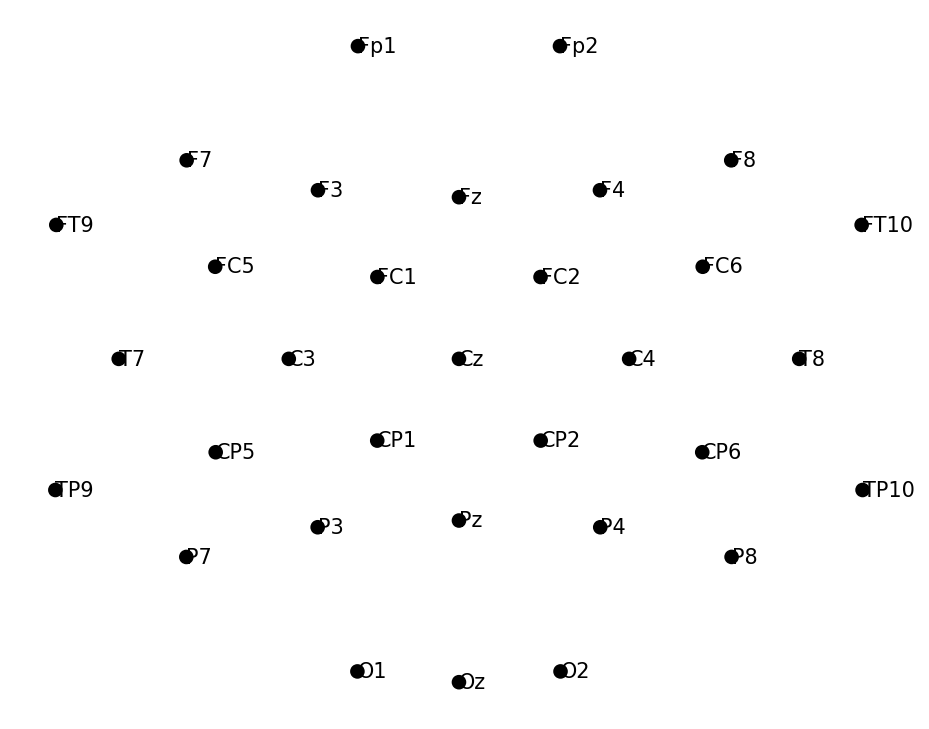

In [3]:
# Load data
data_path = os.path.join(data_dir, data_file)
raw_data = mne.io.read_raw_eeglab(data_path, preload=True, verbose=False)

# Show info (dict containing relevant metadata)
print(raw_data.info)

# Display the montage (sensors on the scalp)
plt.rcParams['figure.dpi'] = 150
raw_data.plot_sensors(ch_type='eeg',show_names=True)
plt.show()

## Now let us explore the EEG data.
As previously, the data array has a shape of (channels, time). We use the `get_data()` method to obtain the EEG array.

In [4]:
data_array = raw_data.get_data()

# Print the shape of the data
print(data_array.shape)

(32, 143722)


As previously stated, this data was acquired using a sampling frequency of 500Hz. We can recover this parameter from the `info` structure. This will be useful as we progress, but for now let's find out how long our data is in seconds.

In [5]:
sfreq = raw_data.info['sfreq']  # Sampling frequency
seconds = data_array.shape[-1] // sfreq
print(f'Data duration in seconds: {seconds} (around {seconds // 60} minutes)')

Data duration in seconds: 287.0 (around 4.0 minutes)


Data can be conveniently plotted from the raw object directly, allowing us some handy operations like filtering the data before displaying

Setting up band-pass filter from 2 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 200.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


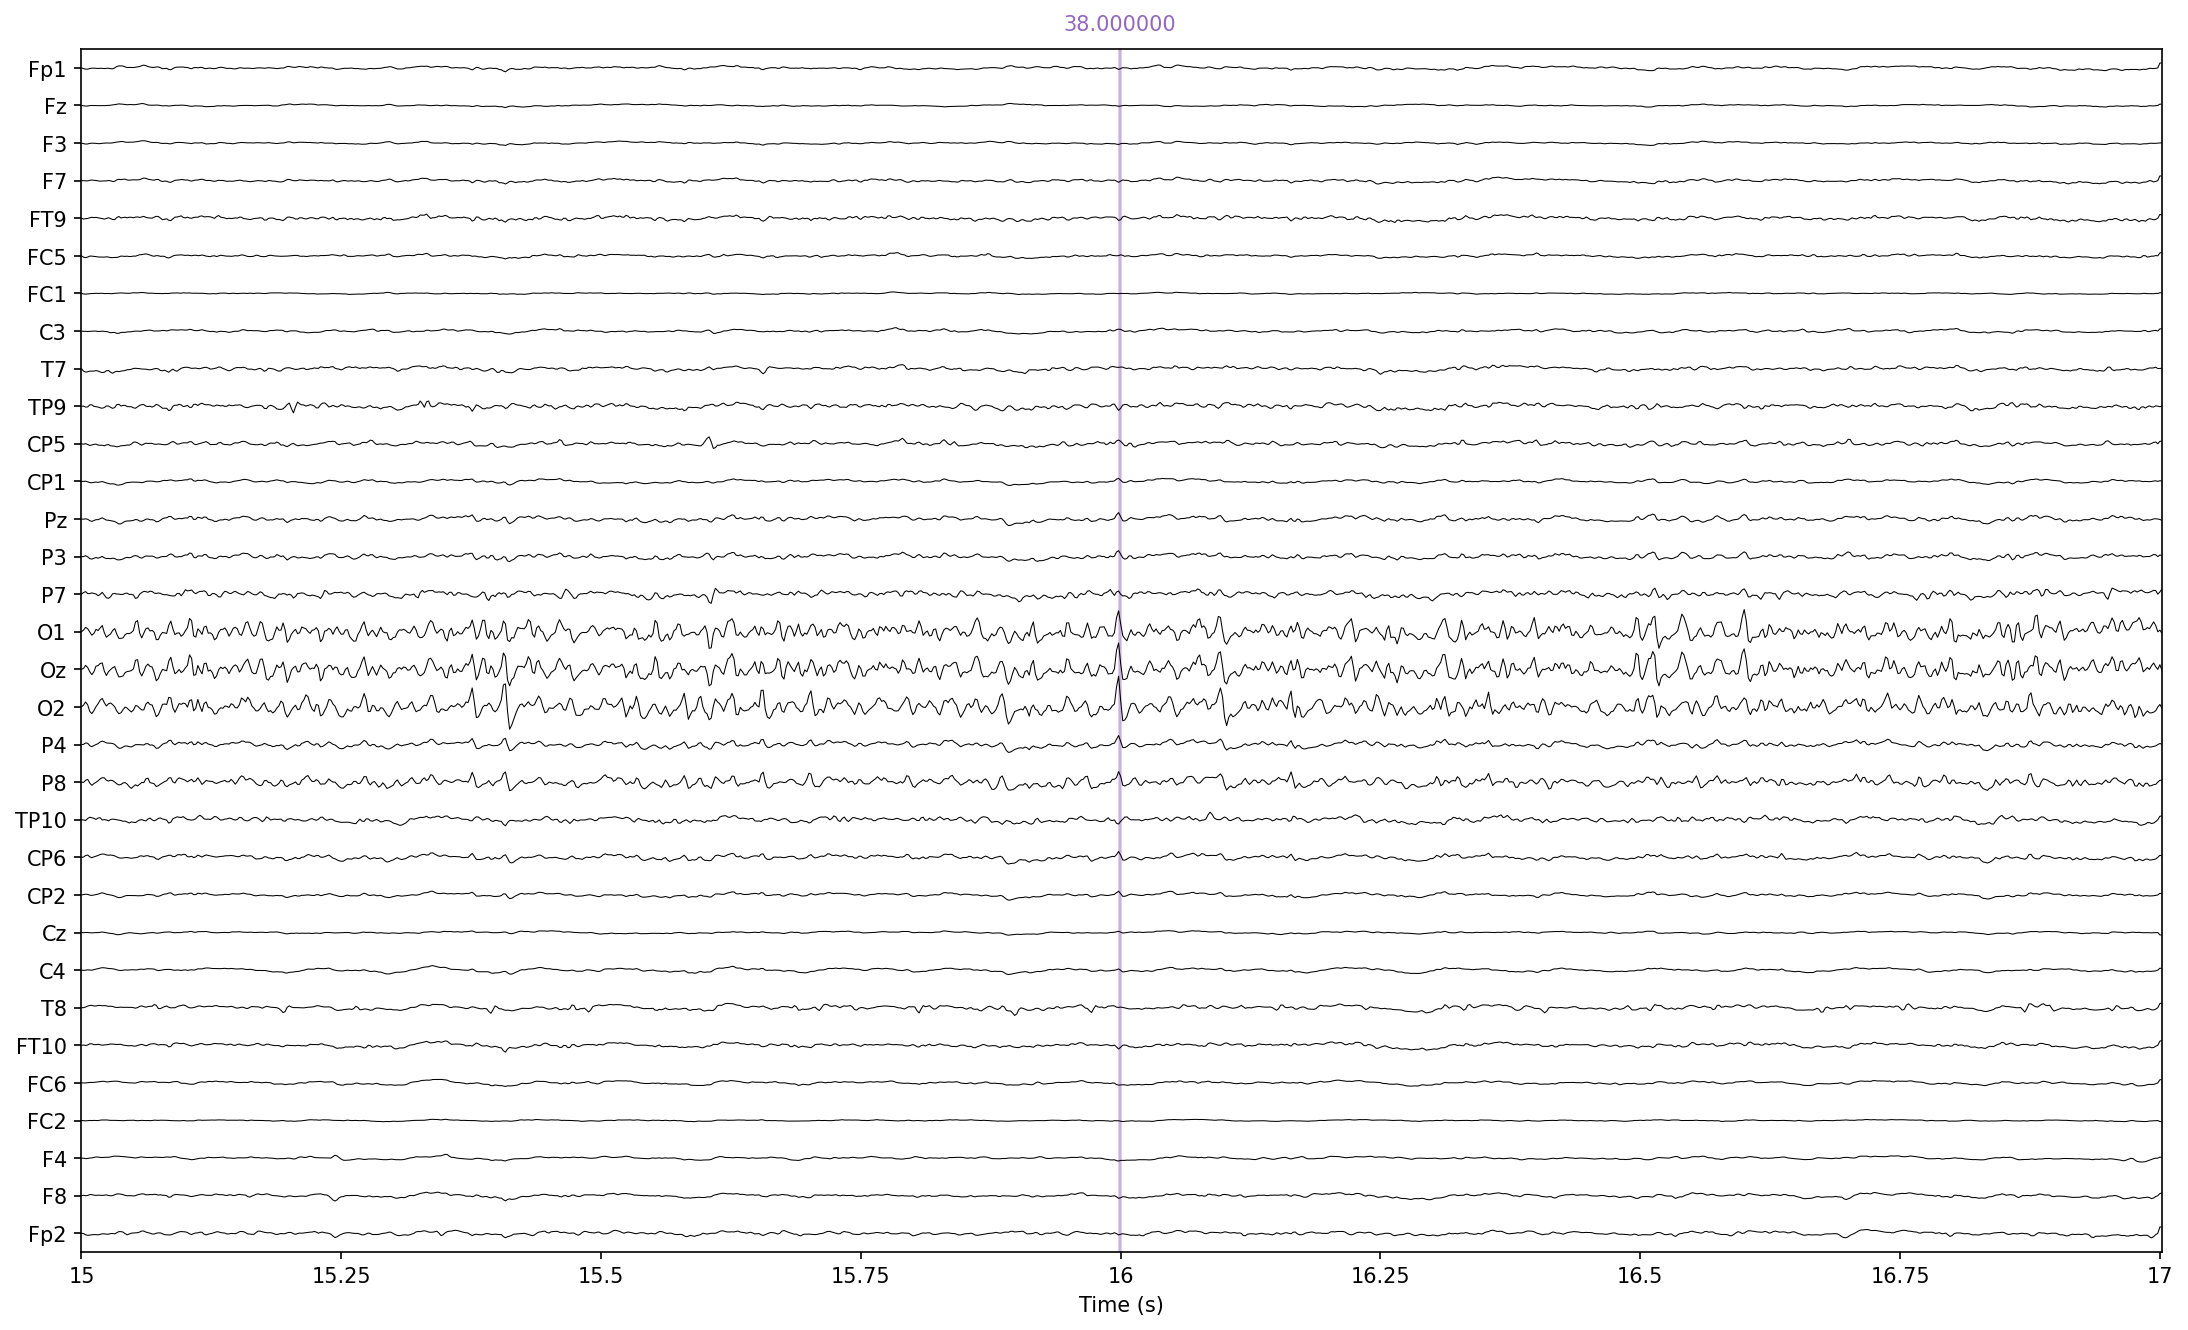

In [6]:
plt.rcParams['figure.dpi'] = 150
scal = dict(eeg=1e-4)                      # EDIT ME!
raw_data.plot(n_channels=32, scalings=scal,
              start=15, duration=2,             # EDIT ME!
              lowpass=200, highpass=2,          # EDIT ME!
              show_scrollbars=False, show_scalebars=False)
plt.show()

### Let's explore some of the events
In this case, we find the events on an annotation file. Several ways of storing events exist, please refer to [the MNE documentation](https://mne.tools/dev/auto_tutorials/raw/20_event_arrays.html) to learn more about how to interact with different types of events. Here, we use the `events_from_annotations()` function to load them.

In [7]:
# Annotations are part of the raw object
print(raw_data.annotations)
print()

# We load the events and the event_id
events, event_id = mne.events_from_annotations(raw_data, verbose=False)

# event_id is a dictionary that related each label to their event name
print(event_id)
print()

# The events are a list where each element is a 3-element list. The first element is the onset of the event, and the last one is the label according to event_id
print(events[:10])

<Annotations | 60 segments: 32.000000 (15), 34.000000 (15), 36.000000 ...>

{'32.000000': 1, '34.000000': 2, '36.000000': 3, '38.000000': 4}

[[ 6149     0     1]
 [ 7999     0     4]
 [ 9849     0     3]
 [11699     0     2]
 [14041     0     2]
 [15891     0     4]
 [17741     0     1]
 [19591     0     3]
 [22009     0     4]
 [23859     0     2]]


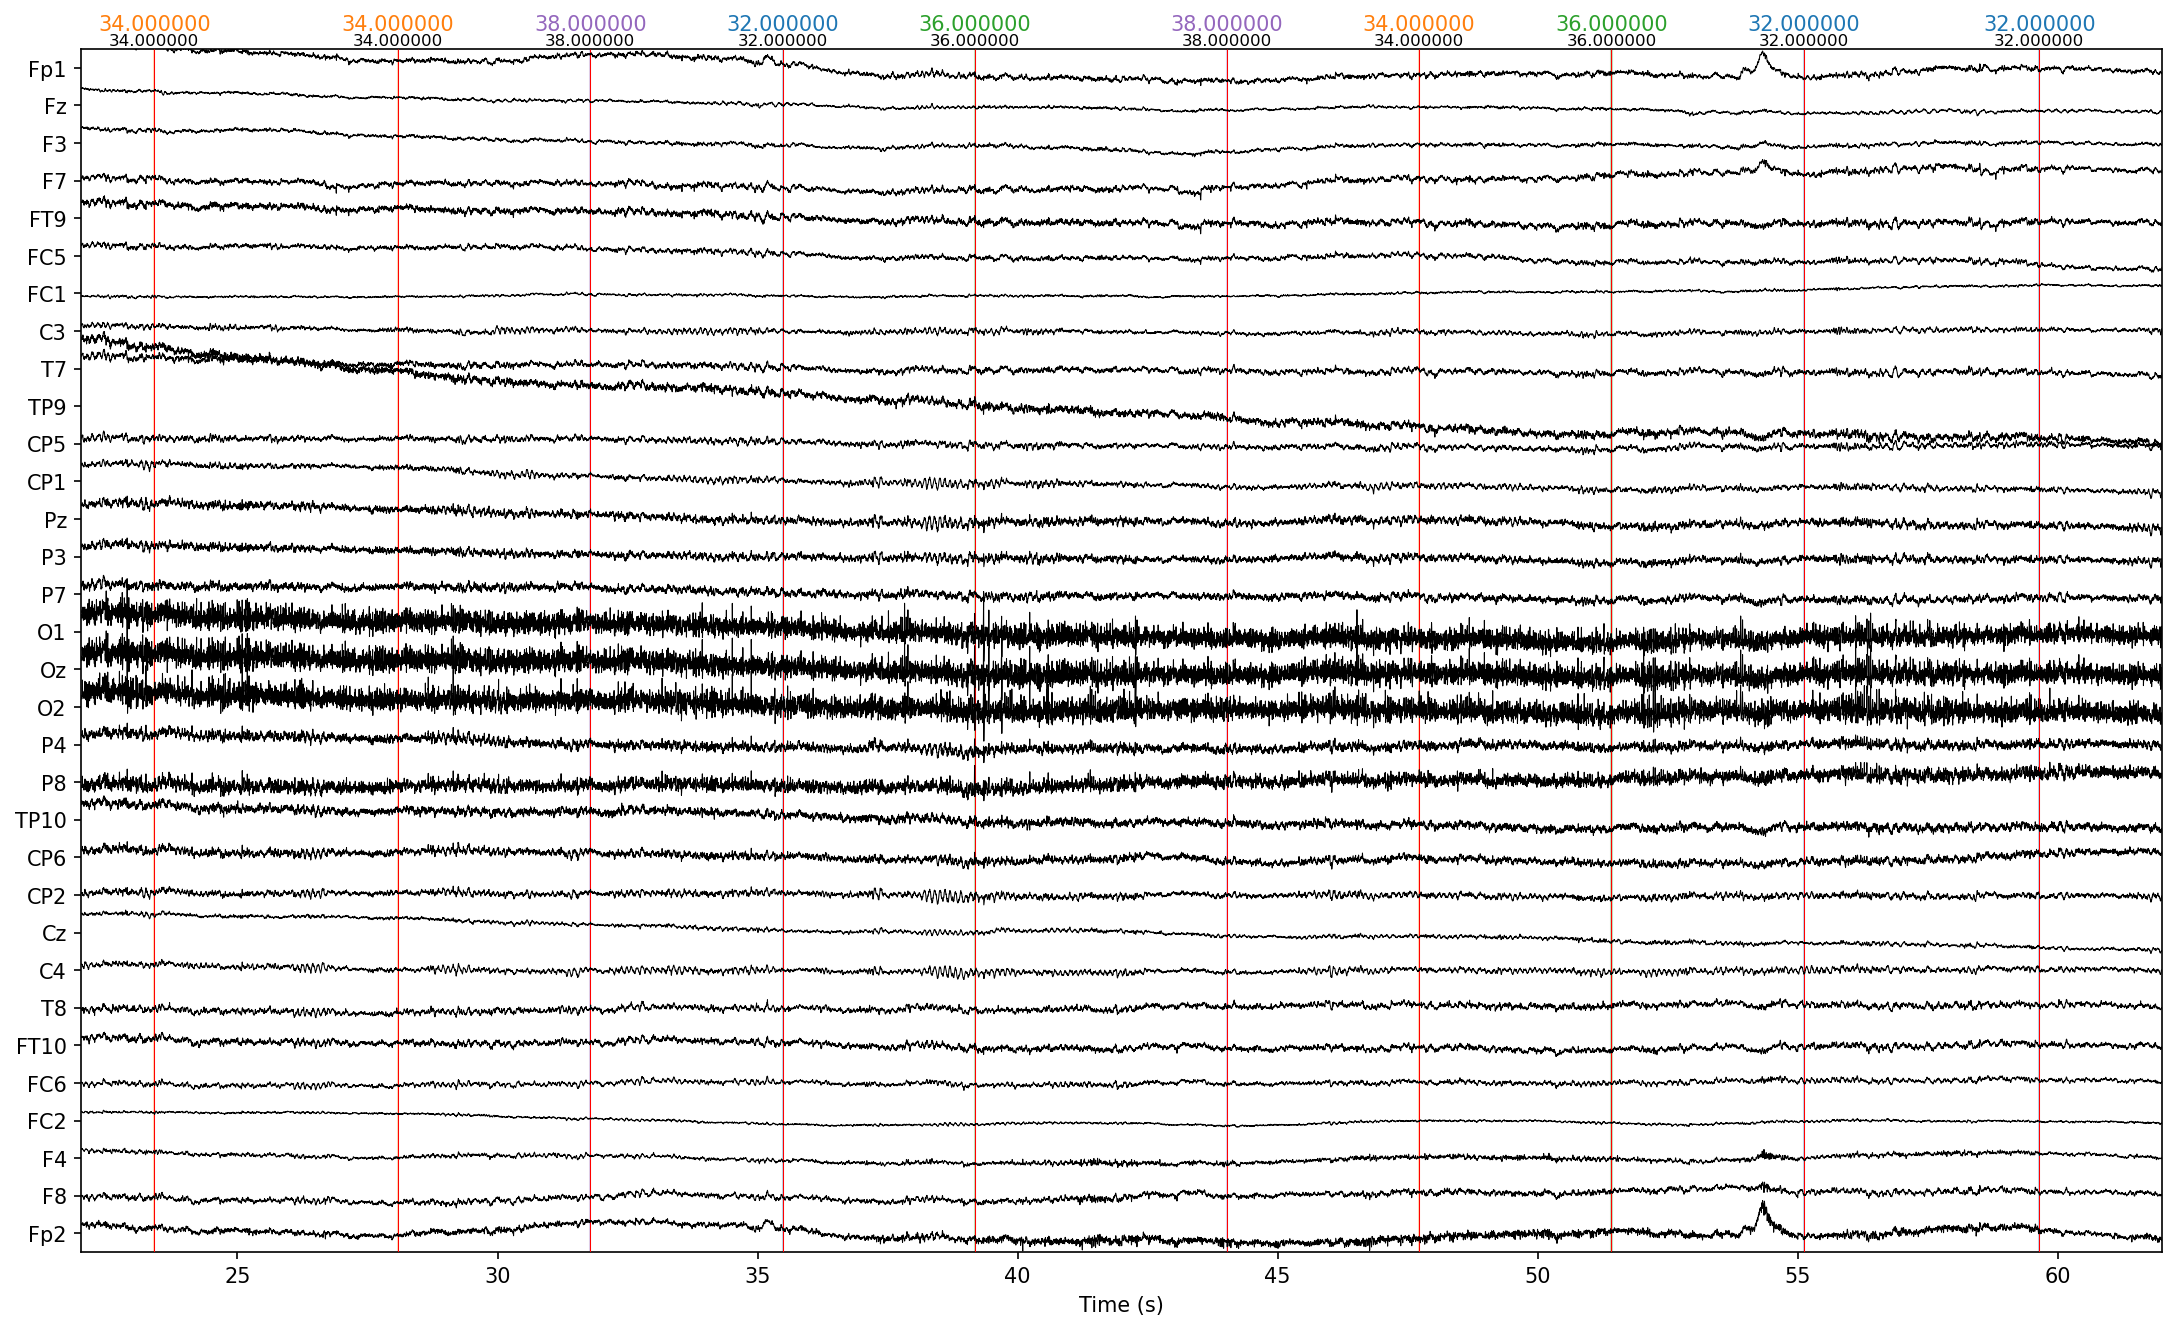

In [8]:
# Display EEG signal with some events
scal = dict(eeg=1e-4)     # EDIT ME!
plt.rcParams['figure.dpi'] = 150
raw_data.plot(events=events, event_color='red', event_id=event_id,
              scalings=scal, clipping=None, show_scrollbars=False, show_scalebars=False, 
              start=22, duration=40,  # EDIT ME!
              n_channels=32)
plt.show()

## Preprocessing Pipeline
We do not see a lot going on, for that we will have to move to the **frequency domain**, where we will be able to see and capture differences in frequency. Before that, we will have to pre-process the data. Different analysis require different pre-processing pipelines, and this time we will:

- Keep the relevant channels
- Band-pass filter the data
- Epoch the data

The only step that is new to this analysis is to keep a selection of channels. We will see an example first.

In [9]:
# To keep a selection of channels, first select the channels we want to keep
ch_to_keep = ["Fp1", "Fp2"]

# Make a list of the channels to drop
ch_to_drop = list(set(raw_data.ch_names) - set(ch_to_keep))
print(ch_to_drop)  # All the channels except ch_to_keep

# Drop the rest of the channels using the drop_channels() function
raw_data = raw_data.drop_channels(ch_to_drop)

['Pz', 'Cz', 'FC6', 'O2', 'F8', 'CP6', 'F3', 'FC1', 'CP1', 'T7', 'P4', 'C4', 'P3', 'CP2', 'P7', 'TP10', 'P8', 'FT9', 'F4', 'C3', 'FT10', 'FC5', 'F7', 'TP9', 'Fz', 'CP5', 'FC2', 'Oz', 'O1', 'T8']


**Question**: Load, pre-process, and epoch the data of a different subject using the functions presented until now. 

- Keep all the channels on the occipital (O) and parieto-occipital (PO) area
- Keep in mind the frequency of the stimuli for filtering (i.e., make sure to capture all the stimulation frequencies)
- Epoch between 0 and 2s, with a baseline of (0.2, 2)

In [10]:
# Load the data 
question_file = 'P5_high_100.set'

data_path = os.path.join(data_dir, question_file)
raw_data = mne.io.read_raw_eeglab(data_path, preload=True, verbose=False)  # HERE

# Get events and event_id
events, event_id = mne.events_from_annotations(raw_data, verbose=False)  # HERE

# Drop all channels except selection
ch_to_keep = ["PO7", "PO3", "POz", "PO4", "PO8", "O1", "Oz", "O2"]  # HERE
ch_to_drop = list(set(raw_data.ch_names) - set(ch_to_keep))  # HERE

raw_data = raw_data.drop_channels(ch_to_drop)  # HERE

# Filter the data
raw_data = raw_data.filter(l_freq=3, h_freq=None, method="iir", verbose=False)  # HERE

# Epoch the data
epochs = mne.Epochs(raw_data, events, event_id=event_id,  # HERE
                    tmin=0, tmax=2, baseline=(0.2, 2),
                    preload=True, verbose=False)

#### Hints: Functions to use. Open if you need a reminder of the functions necessary for the avobe exercise

- load data: `mne.io.read_raw_eeglab`
- find events: `mne.events_from_annotations`
- drop channels: `raw_data.drop_channels`
- filter: `raw_data.filter`
- epoch: `mne.Epochs`

#### Additional hints: Check if you feel lost

- You can check the signature of any function (how to call it, arguments, documentation, etc.) adding a '?' after its name in a jupyter notebook cell, for example, try running `mne.events_from_annotations?` on a new cell
- You can check the list of all EEG channels in `raw_data.info['ch_names']`
- You can check the stimulation frequencies with the `event_id` dictionary.

# II - Frequency analysis and signal-to-noise ratio
We will now explore our data in the frequency domain, and use this information to tell apart the different stimulation frequencies. The first step is to calculate the power spectral density (PSD) by calculating the Fourier Transform (FT).

The goal of this section is to separate the data into different frequencies and perform a statistical analysis to see if the difference in information is significative according to the spectral domain.

In [16]:
# Necessary parameters for the FT
tmin = 0.
tmax = 2.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

# In MNE, the FT is a special case of Welch's method
spectrum = epochs.compute_psd('welch',
                              n_fft=int(sfreq * (tmax - tmin)),
                              n_overlap=0, n_per_seg=None,
                              tmin=tmin, tmax=tmax,
                              fmin=fmin, fmax=fmax,
                              window='boxcar',
                              verbose=False)

psds, freqs = spectrum.get_data(return_freqs=True)

Now, we will proceed to calculate the signal-to-noise ratio (SNR). We define it here as a measure of relative power: it’s the ratio of power in a given frequency bin - the ‘signal’ - to a ‘noise’ baseline - the average power in the surrounding frequency bins.

Hence, we need to set some parameters for this baseline - how many neighboring bins should be taken for this computation, and do we want to skip the direct neighbors (this can make sense if the stimulation frequency is not super constant, or frequency bands are very narrow).

Here we provide a function that calculates the SNR: It depends on the PSD we just calculated and the noise of their neighbouring frequencies.

In [18]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """
    Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
        
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
        
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring frequencies
    averaging_kernel = np.concatenate((np.ones(noise_n_neighbor_freqs), 
                                       np.zeros(2 * noise_skip_neighbor_freqs + 1), 
                                       np.ones(noise_n_neighbor_freqs)))
    
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the averaging kernel
    mean_noise = np.apply_along_axis(lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'), 
                                     axis=-1, arr=psd)

    # The mean is not defined on the edges so we will pad it with nas. The padding needs to be done 
    # for the last dimension only so we set it to (0, 0) for the other ones
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

Now we call the function to compute our SNR spectrum.

As described above, we have to define two parameters.

- How many noise bins do we want?

- Do we want to skip the n bins directly next to the target bin?

Tweaking these parameters can drastically impact the resulting spectrum, but mainly if you choose extremes. E.g. if you’d skip very many neighboring bins, broad band power modulations (such as the alpha peak) should reappear in the SNR spectrum. On the other hand, if you skip none you might miss or smear peaks if the induced power is distributed over two or more frequency bins (e.g. if the stimulation frequency isn’t perfectly constant, or you have very narrow bins).

Here, we want to compare power at each bin with average power of the three neighboring bins (on each side) and **skip one bin** directly next to it.

In [19]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

Now, we can plot the psd and the SNR to have an overview of the frequency domain for our data

<ipython-input-20-eb9894aeb7c6>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


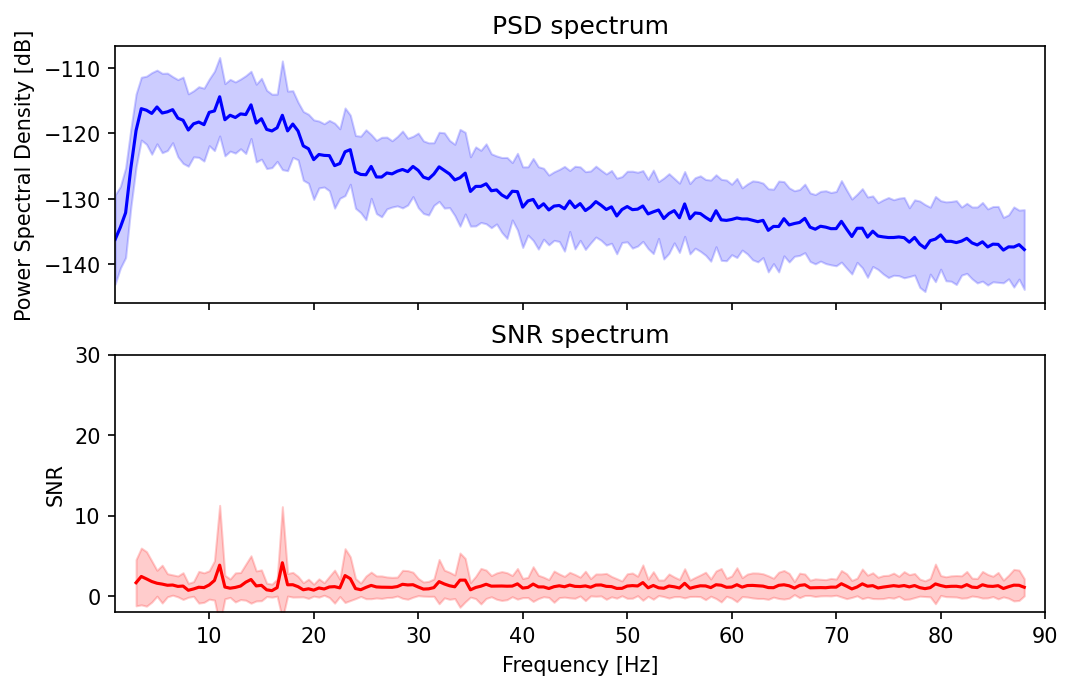

In [20]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()

#### Extract SNR values at stim frequency
Our processing yielded a large array of many SNR values for each trial × channel × frequency-bin of the PSD array.

For statistical analysis we obviously need to define specific subsets of this array. First of all, we are only interested in SNR at the stimulation frequency, but we also want to restrict the analysis to a spatial ROI. Lastly, answering your interesting research questions will probably rely on comparing SNR in different trials.

Therefore we will have to find the indices of trials, channels, etc. Alternatively, one could subselect the trials already at the epoching step, using MNE’s event information, and process different epoch structures separately. Let's only have a look at the trials with 32Hz stimulation:

In [31]:
# Define stimulation frequency 
stim_freq = 32

# Find index of frequency bin closest to stimulation frequency
i_bin_32hz = np.argmin(abs(freqs - stim_freq))

# Indices for different trial types
i_trial_32hz = np.where(epochs.events[:, 2] == event_id['32.000000'])[0]

# Check SNR of the target
snrs_target = snrs[i_trial_32hz, :, i_bin_32hz]
print("sub 2, 12 Hz trials, SNR at 32 Hz")
print(f'average SNR (occipital ROI): {snrs_target.mean()}')

sub 2, 12 Hz trials, SNR at 12 Hz
average SNR (occipital ROI): 4.832197831138288
